In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


In [2]:
#df = pd.read_csv("BRFSS2023_1000.csv") #use for only first 1000 of the brfss. Its such a huge dataset, so this makes testing easier.
df = pd.read_csv("BRFSS2023.csv") 

In [3]:
df.head()

,_state,fmonth,idate,imonth,iday,iyear,dispcode,seqno,_psu,ctelenm1,...,drocdy4_,_rfbing6,_drnkwk2,_rfdrhv8,_flshot7,_pneumo3,_aidtst4,_rfseat2,_rfseat3,_drnkdrv
0,1,1,3012023,3,1,2023,1100,2023000001,2023000001,1.0,...,0,1,0,1,2.0,2.0,2.0,1,1,9
1,1,1,1062023,1,6,2023,1100,2023000002,2023000002,1.0,...,0,1,0,1,1.0,1.0,2.0,1,1,9
2,1,1,3082023,3,8,2023,1100,2023000003,2023000003,1.0,...,0,1,0,1,1.0,1.0,2.0,1,1,9
3,1,1,3062023,3,6,2023,1100,2023000004,2023000004,1.0,...,0,1,0,1,1.0,1.0,1.0,1,1,9
4,1,1,1062023,1,6,2023,1100,2023000005,2023000005,1.0,...,7,1,47,1,2.0,1.0,2.0,1,1,2


In [4]:
#df.columns.tolist()

In [5]:
cols = ['cimemlo1', 'avedrnk3', '_smoker3', 'exerany2', '_rfbmi5', 'genhlth']
# cimemlo1: current memory loss [1 = yes, 2 = no, 7/9 dont know/refused]
# avedrnk3: average number of drinks per day [1-76 drinks in the past 30 days, 88 = None, 77/99 = Dont know/refused]
# _smoker3: current smoking status [1 = current daily smoker, 2 = current some days smoker, 3 = former smoker, 4 = never smoked, 9 = Dont know/refused]
# exerany2: exercise frequency monthly [1 = yes, 2 = no, 7/9 dont know/refused]
# _rfbmi5: adults who have a BMI > 25.00 [1 = No, 2 = Yes, 9 = dont know/refused]
# genhlth: self-reported general health status [1 = Excellent -> 5 = Poor, 7/9 dont know/refused]
# sdhstre1: self-reported stress within last 30 days [1 = Always -> 5 = Never, 7/9 dont know/refused]


In [6]:
dn = df[cols].dropna() #drop null vals


In [7]:
interest = dn[(dn['cimemlo1'] == 1) | (dn['cimemlo1'] == 2)].copy() #keep mem loss to only yes or no
interest['cimemlo1'] = interest['cimemlo1'].replace({1: 1, 2: 0}) #replace with traditional boolean values to make it easier to work with
interest['_rfbmi5'] = interest['_rfbmi5'].replace({1: 0, 2: 1}) #replace with traditional boolean values to make it easier to work with
interest['avedrnk3'] = interest['avedrnk3'].replace({88: 0})
interest['exerany2'] = interest['exerany2'].replace({1: 1, 2: 0}) #replace with traditional boolean values to make it easier to work with


invalid = [7, 9, 77, 99, 88, 777]
drnkinv = [77, 99, 777]

rows_to_drop = interest[ #Claude AI assistance to help make dropping easier
    (interest['avedrnk3'].isin(drnkinv)) |
    (interest['_smoker3'].isin(invalid)) |
    (interest['exerany2'].isin(invalid)) |
    (interest['_rfbmi5'].isin(invalid)) |
    (interest['genhlth'].isin(invalid))
].index
clean = interest.drop(rows_to_drop)


In [8]:
clean.head(15)

,cimemlo1,avedrnk3,_smoker3,exerany2,_rfbmi5,genhlth
4,1.0,1.0,4,1.0,1,4.0
5,1.0,2.0,4,1.0,1,3.0
12,1.0,1.0,3,1.0,1,2.0
18,0.0,2.0,1,0.0,1,3.0
19,0.0,1.0,3,1.0,1,3.0
22,0.0,1.0,4,1.0,0,2.0
29,0.0,1.0,4,0.0,0,2.0
30,0.0,1.0,3,1.0,1,2.0
34,0.0,4.0,4,1.0,1,3.0
41,0.0,1.0,3,1.0,0,2.0


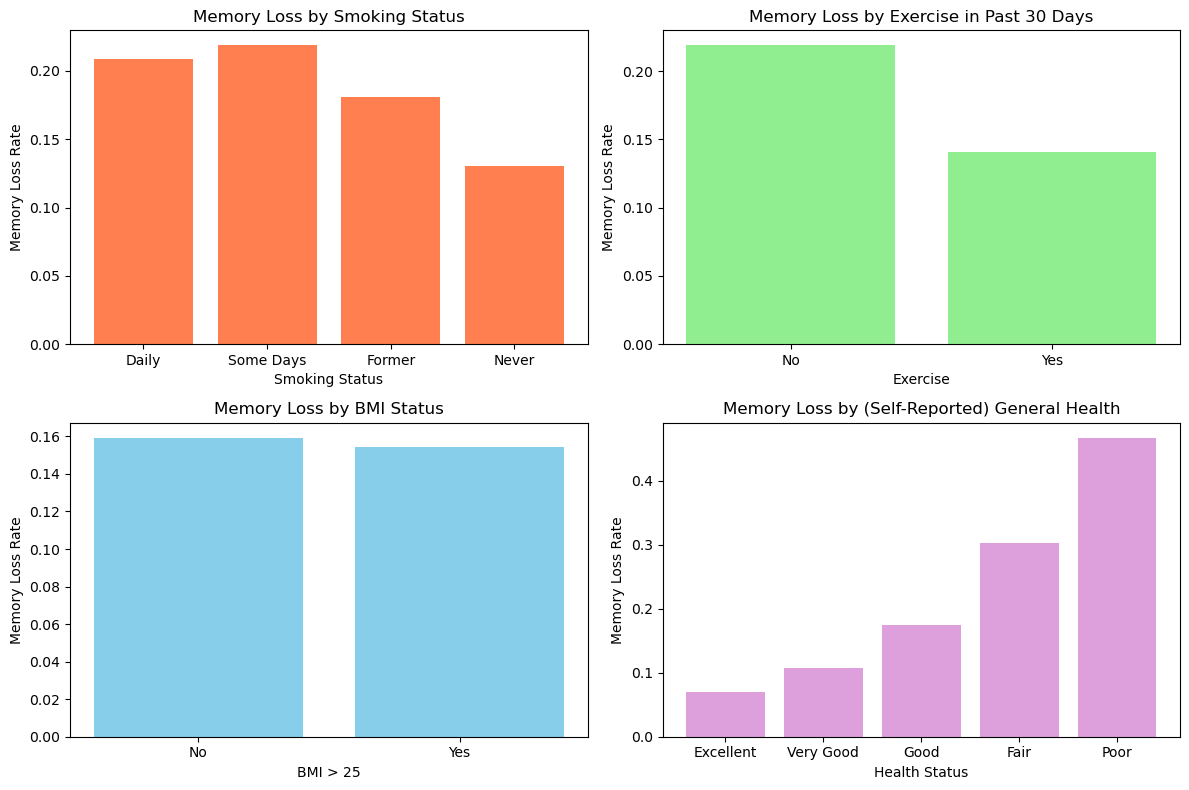

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Smoking
smoking_data = clean.groupby('_smoker3')['cimemlo1'].mean()
axes[0,0].bar(smoking_data.index, smoking_data.values, color='coral')
axes[0,0].set_title('Memory Loss by Smoking Status')
axes[0,0].set_xlabel('Smoking Status')
axes[0,0].set_ylabel('Memory Loss Rate')
axes[0,0].set_xticks([1, 2, 3, 4])
axes[0,0].set_xticklabels(['Daily', 'Some Days', 'Former', 'Never'])

# Exercise
exercise_data = clean.groupby('exerany2')['cimemlo1'].mean()
axes[0,1].bar(exercise_data.index, exercise_data.values, color='lightgreen')
axes[0,1].set_title('Memory Loss by Exercise in Past 30 Days')
axes[0,1].set_xlabel('Exercise')
axes[0,1].set_ylabel('Memory Loss Rate')
axes[0,1].set_xticks([0, 1])
axes[0,1].set_xticklabels(['No', 'Yes'])

# BMI
bmi_data = clean.groupby('_rfbmi5')['cimemlo1'].mean()
axes[1,0].bar(bmi_data.index, bmi_data.values, color='skyblue')
axes[1,0].set_title('Memory Loss by BMI Status')
axes[1,0].set_xlabel('BMI > 25')
axes[1,0].set_ylabel('Memory Loss Rate')
axes[1,0].set_xticks([0, 1])
axes[1,0].set_xticklabels(['No', 'Yes'])

# General Health
health_data = clean.groupby('genhlth')['cimemlo1'].mean()
axes[1,1].bar(health_data.index, health_data.values, color='plum')
axes[1,1].set_title('Memory Loss by (Self-Reported) General Health')
axes[1,1].set_xlabel('Health Status')
axes[1,1].set_ylabel('Memory Loss Rate')
axes[1,1].set_xticks([1, 2, 3, 4, 5])
axes[1,1].set_xticklabels(['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])

plt.tight_layout()
plt.show()

In [10]:
X = clean[['avedrnk3', '_smoker3', 'exerany2', '_rfbmi5', 'genhlth']]
y = clean['cimemlo1']

In [11]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
#Create tree
dt = DecisionTreeClassifier(max_depth=4, random_state=42, class_weight='balanced')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)

In [13]:
# Prediction
y_pred = dt.predict(X_test)

In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6780876494023904

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79     15946
         1.0       0.24      0.52      0.33      2879

    accuracy                           0.68     18825
   macro avg       0.57      0.61      0.56     18825
weighted avg       0.79      0.68      0.72     18825


Confusion Matrix:
[[11266  4680]
 [ 1380  1499]]


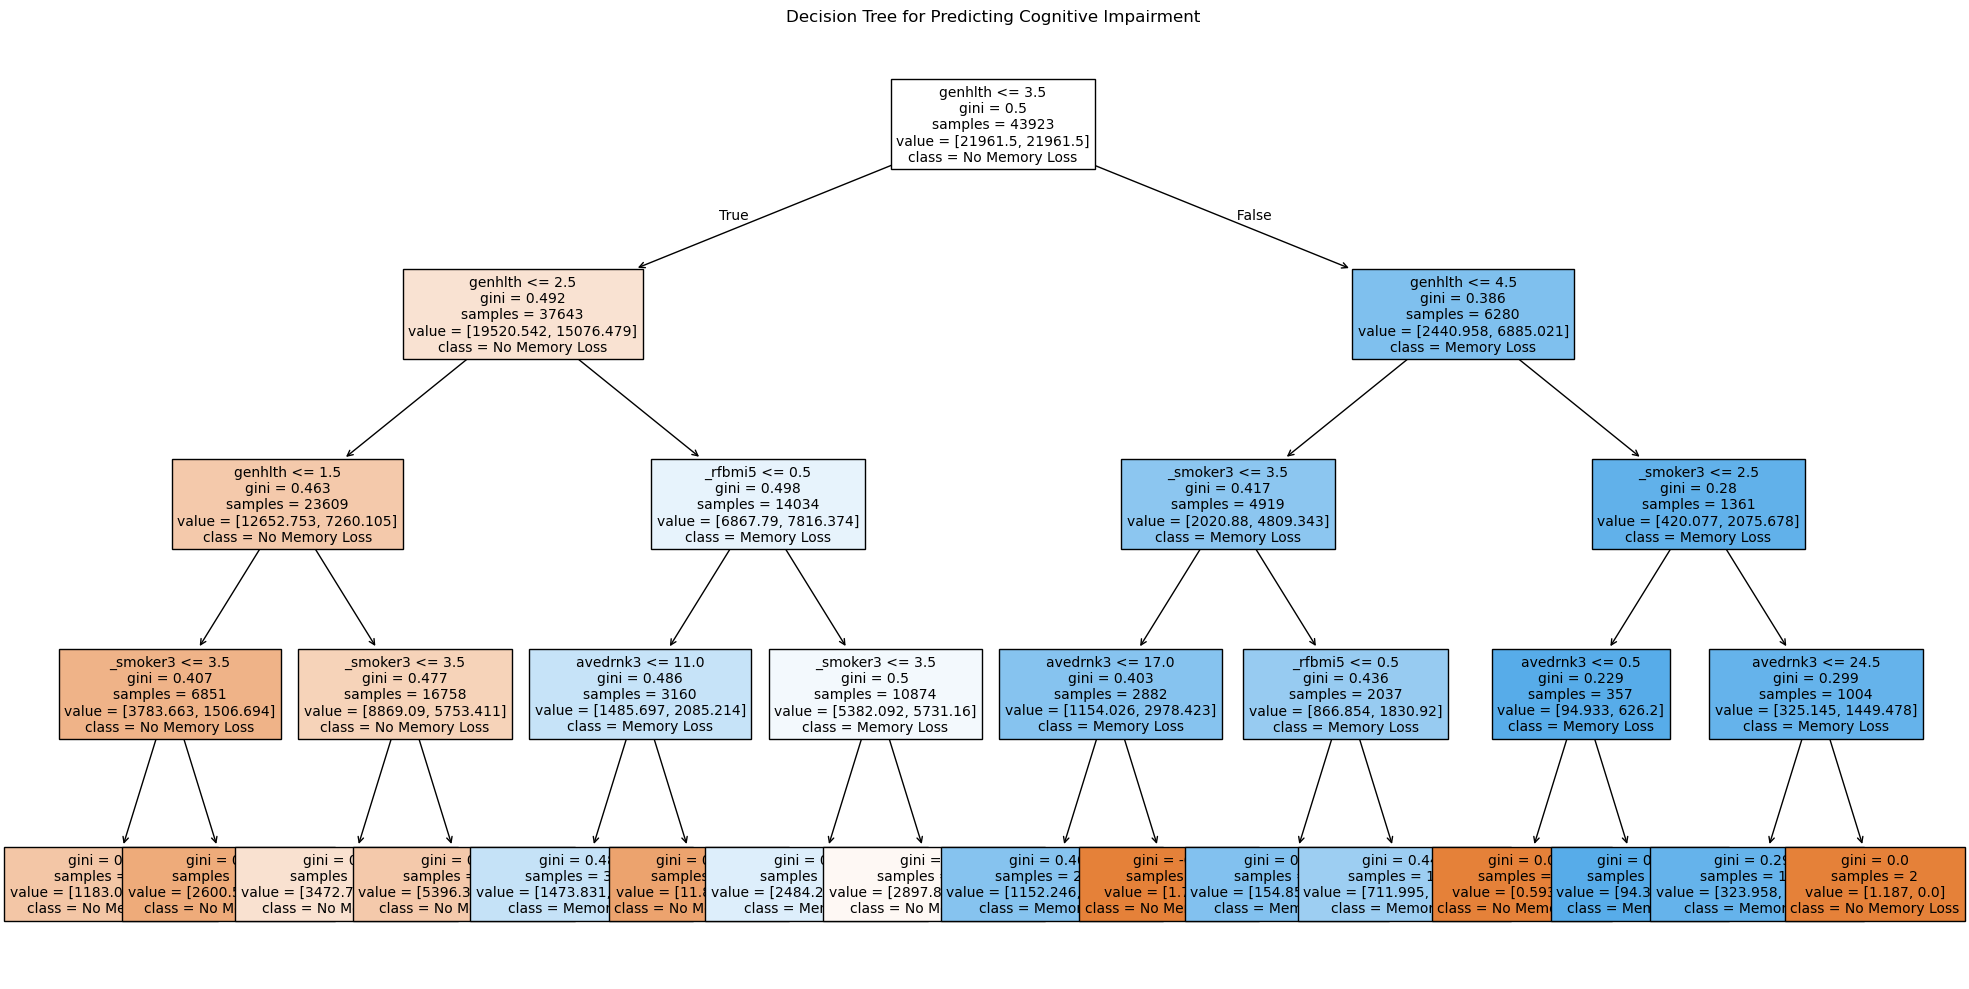

In [15]:
plt.figure(figsize=(20, 10))
tree.plot_tree(dt, 
               feature_names=['avedrnk3', '_smoker3', 'exerany2', '_rfbmi5', 'genhlth'],
               class_names=['No Memory Loss', 'Memory Loss'],
               filled=True,
               fontsize=10)
plt.title('Decision Tree for Predicting Cognitive Impairment')
plt.tight_layout()
plt.show()


Feature Importance:
    feature  importance
4   genhlth    0.939770
1  _smoker3    0.042299
3   _rfbmi5    0.013865
0  avedrnk3    0.004066
2  exerany2    0.000000


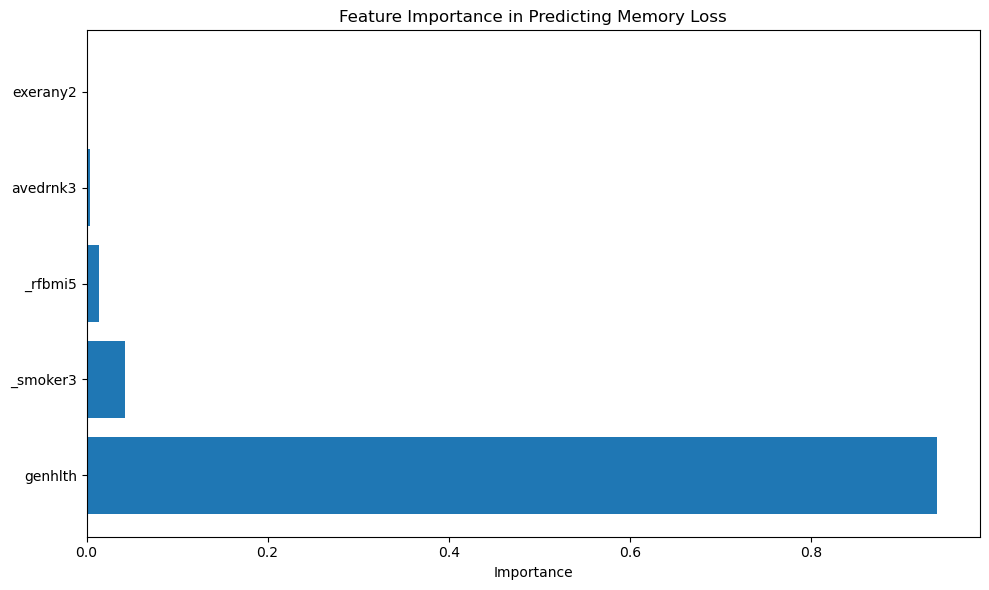

In [16]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': ['avedrnk3', '_smoker3', 'exerany2', '_rfbmi5', 'genhlth'],
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Predicting Memory Loss')
plt.tight_layout()
plt.show()

In [17]:
#Interesting. Gen-health is self reported, so we should probably try without it since it weighs heavily on this one value.

In [18]:

# Prepare the data WITHOUT genhlth
X = clean[['avedrnk3', '_smoker3', 'exerany2', '_rfbmi5']]
y = clean['cimemlo1']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Define the decision tree model
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Parameter grid to search
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, None],
    'min_samples_split': [2, 10, 20, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Grid search
grid = GridSearchCV(
    dt,
    param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='f1',        # optimize for memory-loss class
    n_jobs=-1            # use all CPU cores
)

In [19]:


grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid.best_params_)

# Best estimator
best_dt = grid.best_estimator_

# Predictions
y_pred = best_dt.predict(X_test)

# Evaluation
print("Optimized Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))




Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Optimized Accuracy: 0.5107569721115538

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.49      0.63     15946
         1.0       0.18      0.63      0.28      2879

    accuracy                           0.51     18825
   macro avg       0.53      0.56      0.46     18825
weighted avg       0.77      0.51      0.58     18825


Confusion Matrix:
[[7798 8148]
 [1062 1817]]


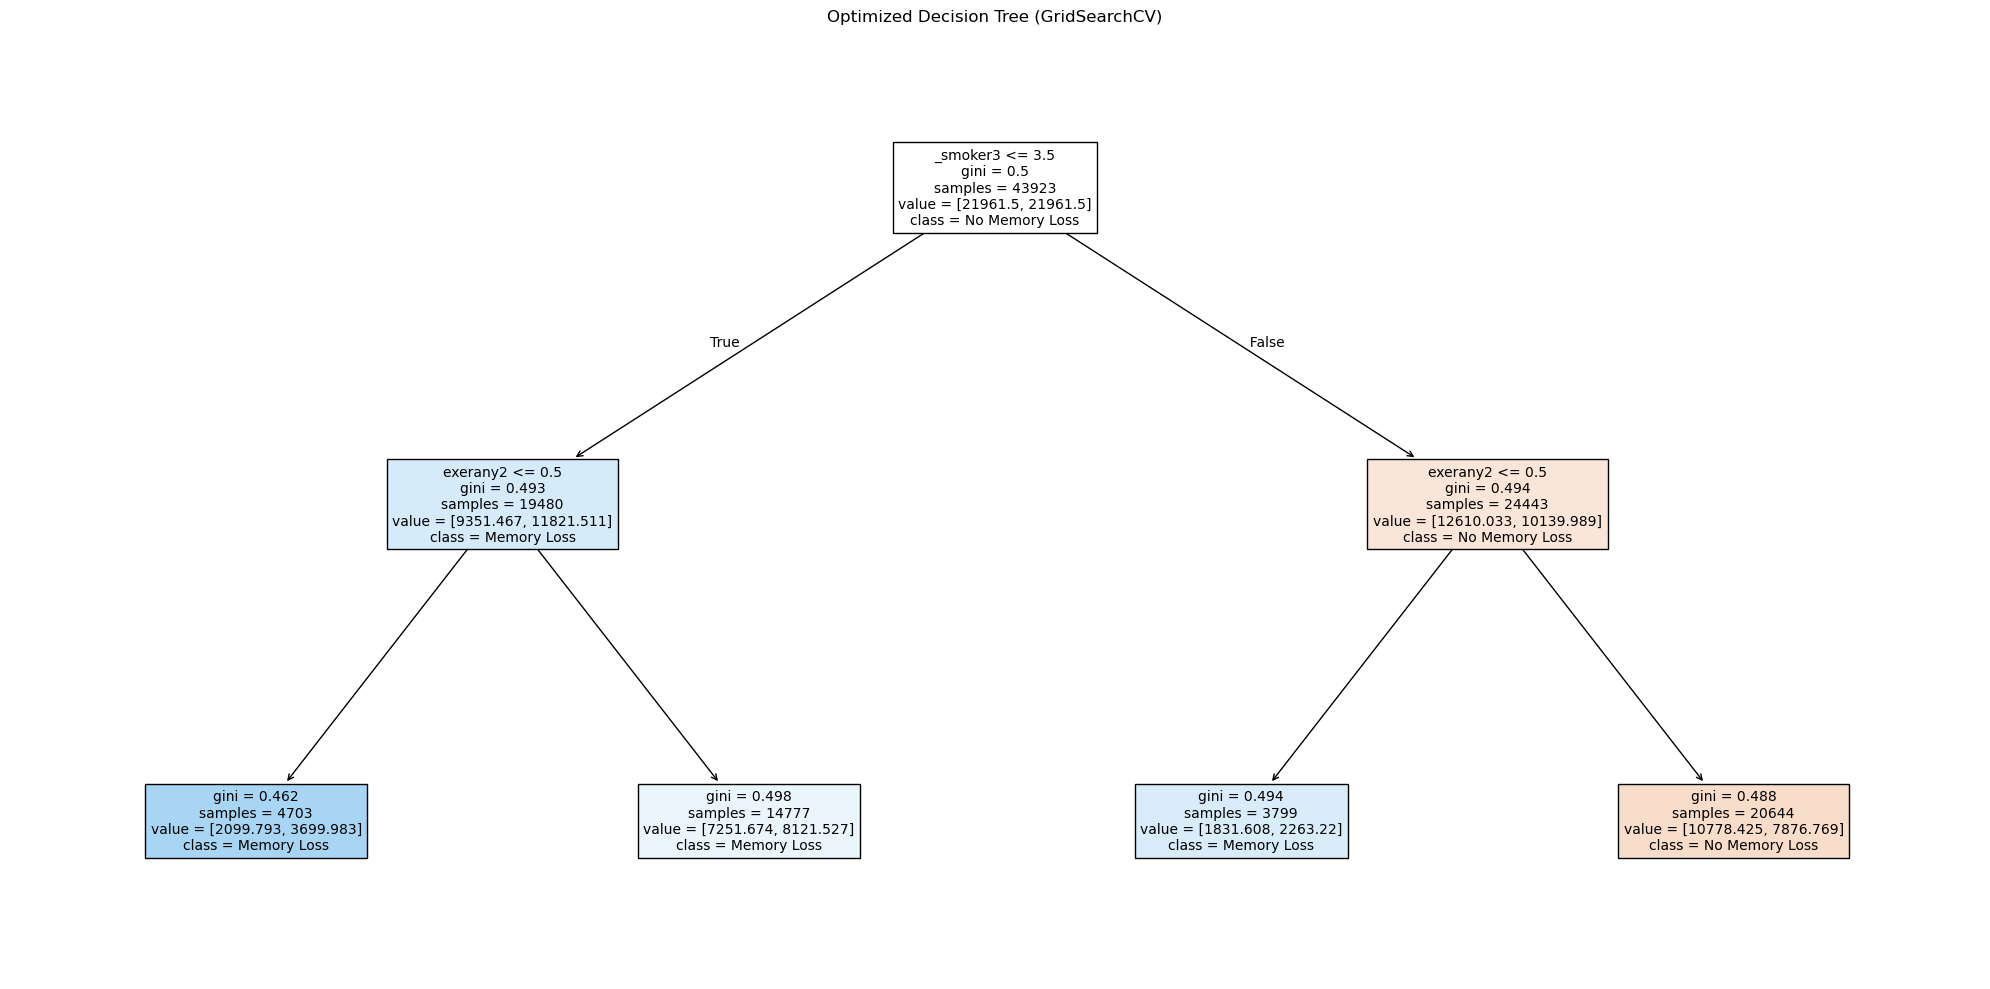

In [20]:
# Visualize the optimized tree
plt.figure(figsize=(20, 10))
tree.plot_tree(
    best_dt,
    feature_names=['avedrnk3', '_smoker3', 'exerany2', '_rfbmi5'],
    class_names=['No Memory Loss', 'Memory Loss'],
    filled=True,
    fontsize=10
)
plt.title('Optimized Decision Tree (GridSearchCV)')
plt.tight_layout()
plt.show()




Feature Importance:
    feature  importance
1  _smoker3    0.563355
2  exerany2    0.436645
0  avedrnk3    0.000000
3   _rfbmi5    0.000000


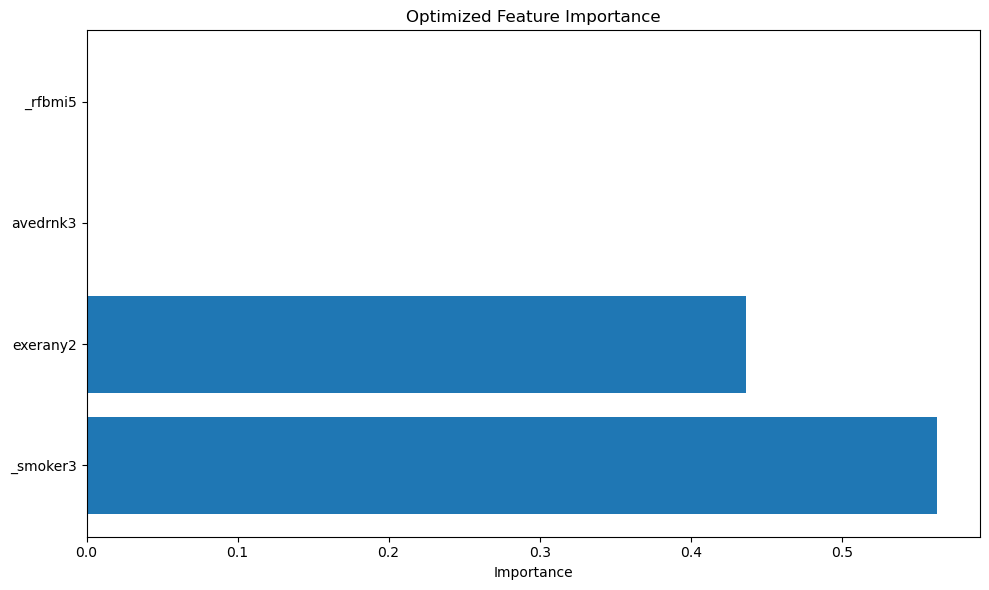

In [21]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': ['avedrnk3', '_smoker3', 'exerany2', '_rfbmi5'],
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Optimized Feature Importance')
plt.tight_layout()
plt.show()

In [22]:
# Are certain lifestyle behaviors associated with increased reports of memory
# loss or cognitive impairment? If so, which behaviors show the strongest correlations?

In [23]:

# Create logistic regression model
log_reg = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluate
print("Logistic Regression Results:")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# Get coefficients (direction and strength of relationships)
coefficients = pd.DataFrame({
    'feature': ['avedrnk3', '_smoker3', 'exerany2', '_rfbmi5'],
    'coefficient': log_reg.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nFeature Coefficients:")
print(coefficients)

Logistic Regression Results:

Accuracy: 0.6861088977423638

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80     15946
         1.0       0.20      0.36      0.26      2879

    accuracy                           0.69     18825
   macro avg       0.53      0.55      0.53     18825
weighted avg       0.76      0.69      0.72     18825


Confusion Matrix:
[[11874  4072]
 [ 1837  1042]]

Feature Coefficients:
    feature  coefficient
2  exerany2    -0.476064
1  _smoker3    -0.202752
3   _rfbmi5    -0.047665
0  avedrnk3     0.008071


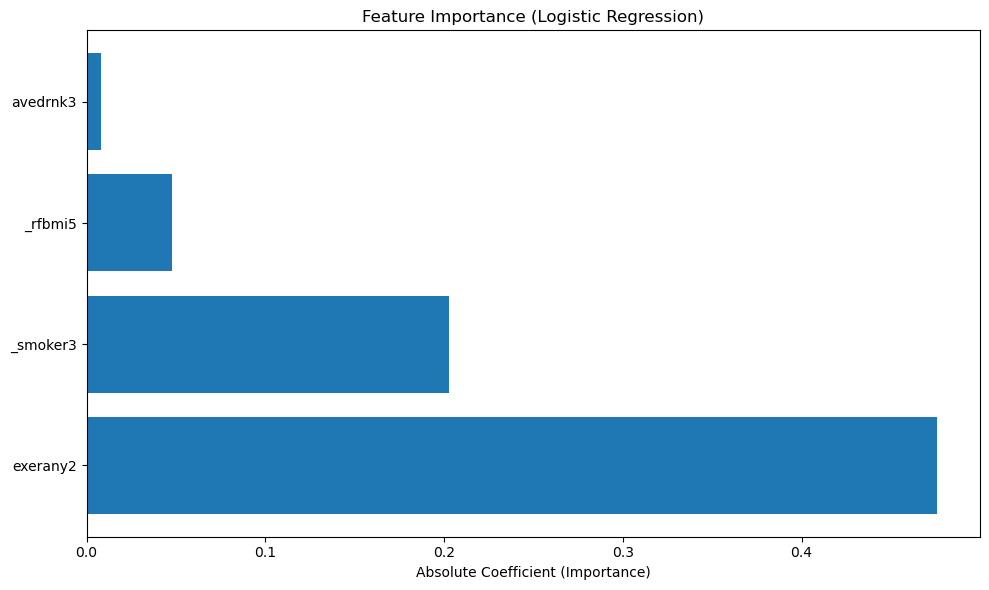

In [26]:
coeff_plot = coefficients.copy()
coeff_plot['abs_coeff'] = coeff_plot['coefficient'].abs()
coeff_plot = coeff_plot.sort_values('abs_coeff', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coeff_plot['feature'], coeff_plot['abs_coeff'])
plt.xlabel('Absolute Coefficient (Importance)')
plt.title('Feature Importance (Logistic Regression)')
plt.tight_layout()
plt.show()